# Hypothesis Testing Movie Info

In [144]:
# Import Libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, json, time
from tqdm.notebook import tqdm_notebook 
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

## Save json files as csv files / dataframes

In [6]:
YEARS_TO_GET = list(range(2010,2021))
api_df = pd.DataFrame()

In [8]:
for year in YEARS_TO_GET:
    # select JSON_FILE name and check if file exists
    JSON_FILE = f'Data/tmdb_api_results_{year}.json'
    
    # convert json file to .csv.gz
    final_year_df = pd.read_json(JSON_FILE)
    final_year_df.to_csv(f'Data/final_tmdb_data_{year}.csv.gz', 
                         compression='gzip',
                        index=False)
    
    api_df = pd.concat([api_df, final_year_df], ignore_index=True)

In [9]:
api_df.info()
api_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40570 entries, 0 to 40569
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                40570 non-null  object 
 1   adult                  40559 non-null  float64
 2   backdrop_path          26186 non-null  object 
 3   belongs_to_collection  2384 non-null   object 
 4   budget                 40559 non-null  float64
 5   genres                 40559 non-null  object 
 6   homepage               37998 non-null  object 
 7   id                     40559 non-null  float64
 8   original_language      40559 non-null  object 
 9   original_title         40559 non-null  object 
 10  overview               40559 non-null  object 
 11  popularity             40559 non-null  float64
 12  poster_path            37225 non-null  object 
 13  production_companies   40559 non-null  object 
 14  production_countries   40559 non-null  object 
 15  re

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0312305,0.0,None,None,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",http://www.qqthemovie.com/,23738.0,en,Quantum Quest: A Cassini Space Odyssey,...,0.0,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,Quantum Quest: A Cassini Space Odyssey,0.0,8.4,7.0,
2,tt0326965,0.0,/xt2klJdKCVGXcoBGQrGfAS0aGDE.jpg,None,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",http://www.inmysleep.com,40048.0,en,In My Sleep,...,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sleepwalking Can Be Deadly,In My Sleep,0.0,5.5,31.0,PG-13
3,tt0331312,0.0,None,None,0.0,[],,214026.0,en,This Wretched Life,...,0.0,0.0,[],Released,,This Wretched Life,0.0,5.0,1.0,
4,tt0393049,0.0,/gc9FN5zohhzCt05RkejQIIPLtBl.jpg,None,300000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",,324352.0,en,Anderson's Cross,...,0.0,98.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sometimes the boy next door is more than the b...,Anderson's Cross,0.0,4.0,5.0,


## Hypothesis Testing

In [10]:
# initialize significance level
alpha = 0.05

### Q1: does the MPAA rating of a movie (G/PG/PG-13/R) affect how much revenue the movie generates?

We will perform an ANOVA test to compare revenue between movies of different MPAA ratings 
- $H_0$: There is no difference in the revenue between movies of different MPAA ratings
- $H_A$: There is a significant difference in revenue between movies of different MPAA ratings

#### Clean certification and revenue columns

In [11]:
# look at different MPAA ratings
api_df['certification'].value_counts()

           14163
R           3307
NR          2404
PG-13       1859
PG           860
G            287
NC-17        111
Unrated        4
R              1
PG-13          1
10             1
Name: certification, dtype: int64

In [33]:
cert_df = api_df[['certification','revenue']].copy()
cert_df.head()

,certification,revenue
0,NaN,NaN
1,,0.0
2,PG-13,0.0
3,,0.0
4,,0.0


In [36]:
cert_df.isna().sum()

certification    17572
revenue             11
dtype: int64

In [38]:
cert_df = cert_df.dropna()
cert_df.isna().sum()

certification    0
revenue          0
dtype: int64

In [39]:
cert_df = cert_df[cert_df['certification'] != '']
cert_df = cert_df[cert_df['certification'] != '10']
cert_df['certification'].value_counts()

R          3308
NR         2404
PG-13      1860
PG          860
G           287
NC-17       111
Unrated       4
Name: certification, dtype: int64

In [40]:
cert_df = cert_df.replace('R ','R')
cert_df = cert_df.replace('PG-13 ','PG-13')
cert_df['certification'].value_counts()

R          3308
NR         2404
PG-13      1860
PG          860
G           287
NC-17       111
Unrated       4
Name: certification, dtype: int64

In [72]:
cert_df = cert_df[cert_df['certification'] != 'Unrated']
cert_df['certification'].value_counts()

R        3308
NR       2404
PG-13    1860
PG        860
G         287
NC-17     111
Name: certification, dtype: int64

In [73]:
ratings = cert_df['certification'].unique()
ratings

array(['PG-13', 'PG', 'R', 'NR', 'G', 'NC-17'], dtype=object)

#### separate data into groups for each rating

In [74]:
groups = {}
for i in cert_df['certification'].unique():
    data = cert_df.loc[cert_df['certification']==i,'revenue'].copy()
    groups[i] = data
groups.keys()

dict_keys(['PG-13', 'PG', 'R', 'NR', 'G', 'NC-17'])

#### Check for normality

In [80]:
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    norm_results[i] = {'n':len(data),
                      'p':p,
                      'test stat':stat}
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df['sig'] = norm_results_df['p'] > alpha
norm_results_df

,n,p,test stat,sig
PG-13,1860.0,0.000000e+00,1907.213061,False
PG,860.0,3.763211e-162,743.387025,False
R,3308.0,0.000000e+00,4159.475791,False
NR,2404.0,0.000000e+00,5625.825485,False
G,287.0,2.236222e-87,399.040230,False
NC-17,111.0,1.505871e-34,155.757044,False


> None of the MPCC ratings pass the normality test. However, all the utilized groups are greater than 20 in the number of datapoints, so we can continue


#### check for equal variance

In [81]:
stats.levene(*groups.values()).pvalue >alpha

False

> We do not have equal variances in the groups. I will skip the ANOVA test, since we do not meet the assumptions, and go straight to Tukey's pairwise comparisons test. 

#### Perform Tukey's pairwise comparisons test

In [83]:
values = cert_df['revenue']
labels = cert_df['certification']

tukeys_restults = pairwise_tukeyhsd(values, labels)
tukeys_restults.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
G,NC-17,-22813674.2452,0.557,-61935478.4836,16308129.9931,False
G,NR,-21929479.4738,0.0487,-43788386.6654,-70572.2822,True
G,PG,49697468.1683,0.0,25837420.2096,73557516.1269,True
G,PG-13,52084441.6108,0.0,29887232.2099,74281651.0117,True
G,R,-6182105.4503,0.9643,-27720113.0495,15355902.1489,False
NC-17,NR,884194.7714,1.0,-33095545.1857,34863934.7285,False
NC-17,PG,72511142.4135,0.0,37210819.5746,107811465.2524,True
NC-17,PG-13,74898115.856,0.0,40699767.8092,109096463.9027,True
NC-17,R,16631568.795,0.7249,-17142632.5321,50405770.122,False
NR,PG,71626947.6421,0.0,57719789.4393,85534105.8449,True


There are 5 significant results in which we fail to reject the null hypothesis that there is no significant difference in revenue between movies of different ratings.
- G vs. NC-17
- G vs. R
- NC-17 vs NR
- NC-17 vs R
- PG vs PG-13

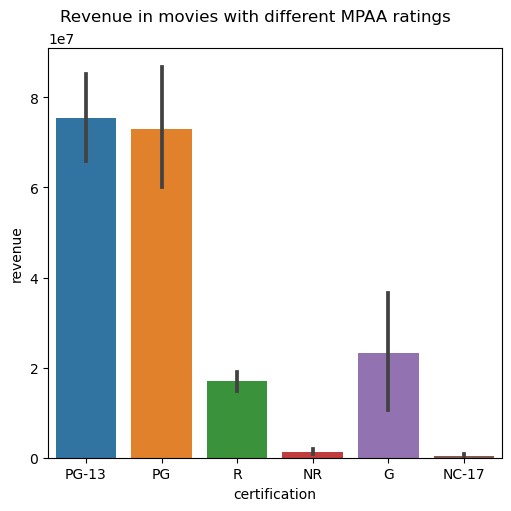

In [155]:
fig, ax = plt.subplots(figsize= (5,5), ncols=1, 
                                constrained_layout=True)
sns.barplot(data = cert_df, x='certification',y='revenue')
fig.suptitle('Revenue in movies with different MPAA ratings');

### Q2: Do movies that are over 2.5 hours long earn more revenue than movies that are 1.5 hours long (or less)?

We will perform an 2 sample t-test to compare revenue between movies of different lengths
- $H_0$: There is no difference in the revenue between movies that are over 2.5 hours long vs. movies that are 1.5 hours or less
- $H_A$: There is a significant difference in revenue between movies that are over 2.5 hours long vs. movies that are 1.5 hours or less

#### Clean runtime and revenue columns

In [89]:
long = 60*2.5
short = 60*1.5
print(f'long:{long}, short:{short}')

long:150.0, short:90.0


In [86]:
run_df = api_df[['runtime','revenue']].copy()
run_df

,runtime,revenue
0,NaN,NaN
1,45.0,0.0
2,90.0,0.0
3,0.0,0.0
4,98.0,0.0
...,...,...
40565,92.0,0.0
40566,92.0,0.0
40567,103.0,0.0
40568,0.0,0.0


In [90]:
run_df['length'] = ['long' if x>=long else 'short' if x <=short else 'none' for x in run_df['runtime']]
run_df['length'].value_counts()

none     22149
short    17634
long       787
Name: length, dtype: int64

In [91]:
run_df = run_df[run_df['length'] != 'none']
run_df['length'].value_counts()

short    17634
long       787
Name: length, dtype: int64

In [92]:
run_df.isna().sum()

runtime    0
revenue    0
length     0
dtype: int64

#### split into two groups

In [95]:
movies_long = run_df.loc[run_df['length']=='long', 'revenue']
movies_short = run_df.loc[run_df['length']=='short', 'revenue']

#### check for and remove outliers

In [96]:
zscores = stats.zscore(movies_long)
outliers = abs(zscores)>3
np.sum(outliers)

11

In [97]:
movies_long = movies_long[(np.abs(stats.zscore(movies_long))<3)]

In [98]:
zscores = stats.zscore(movies_short)
outliers = abs(zscores)>3
np.sum(outliers)

86

In [99]:
movies_short = movies_short[(np.abs(stats.zscore(movies_short))<3)]

#### check for normality

In [100]:
result = stats.normaltest(movies_long)
print(f'p-value: {result.pvalue}')
result.pvalue > alpha

p-value: 3.7788671226094765e-215


False

In [101]:
result = stats.normaltest(movies_short)
print(f'p-value: {result.pvalue}')
result.pvalue > alpha

p-value: 0.0


False

> p-values for both groups are well below alpha = 0.05, which means our data is NOT normally distributed. However, our sample size is large enough to proceed without satisfying this test.

#### check for equal variance

In [102]:
result = stats.levene(movies_long, movies_short)
print(f'p-value: {result.pvalue}')
result.pvalue > alpha

p-value: 2.4064928915729355e-169


False

> The two groups DO NOT have equal variances. Therefore, we need to be sure to include "equal_var = False" when we perform the t-test.

#### perform and evaluate t-test

In [103]:
result = stats.ttest_ind(movies_long, movies_short, equal_var=False)
print(f'p-value: {result.pvalue}')
result.pvalue > alpha

p-value: 2.913475655272334e-09


False

> Based on the p-value of the t-test being < alpha (0.05), we reject the null hypothesis. Therefore, we conclude that **there is a significant difference in revenue between movies that are over 2.5 hours long vs. movies that are 1.5 hours or less.**

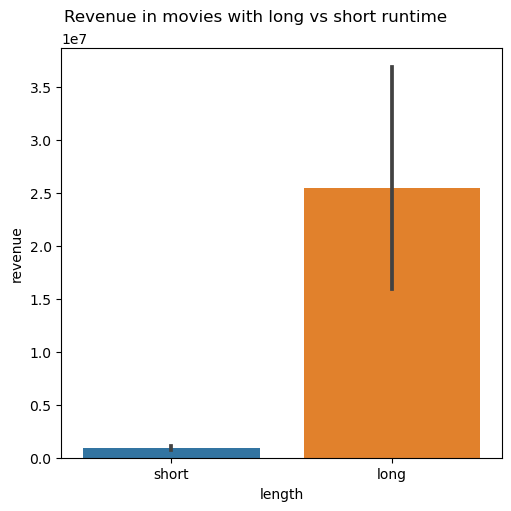

In [153]:
fig, ax = plt.subplots(figsize= (5,5), ncols=1, 
                                constrained_layout=True)
sns.barplot(data = run_df, x='length',y='revenue')
fig.suptitle('Revenue in movies with long vs short runtime');

### Q3: Do movies released in 2020 earn less revenue than movies released in 2018?

We will perform an 2 sample t-test to compare revenue between movies released in 2018 vs 2020
- $H_0$: There is no difference in the revenue between movies released in 2018 vs 2020
- $H_A$: There is a significant difference in revenue between movies released in 2018 vs 2020

#### split into two groups

In [116]:
api_2018 = pd.read_csv('Data/final_tmdb_data_2018.csv.gz')
api_2020 = pd.read_csv('Data/final_tmdb_data_2020.csv.gz')

In [117]:
api_2018 = api_2018[['imdb_id','revenue']]
api_2020 = api_2020[['imdb_id','revenue']]

In [121]:
api_2018 = api_2018.dropna()
api_2020 = api_2020.dropna()

In [124]:
rev_2018 = api_2018['revenue'].values
rev_2020 = api_2020['revenue'].values
print(f'Datapoint count in 2018 group: {len(rev_2018)}')
print(f'Datapoint count in 2020 group: {len(rev_2020)}')

Datapoint count in 2018 group: 4519
Datapoint count in 2020 group: 3717


#### check for and remove outliers

In [125]:
zscores = stats.zscore(rev_2018)
outliers = abs(zscores)>3
np.sum(outliers)

39

In [126]:
rev_2018 = rev_2018[(np.abs(stats.zscore(rev_2018))<3)]

In [127]:
zscores = stats.zscore(rev_2020)
outliers = abs(zscores)>3
np.sum(outliers)

17

In [128]:
rev_2020 = rev_2020[(np.abs(stats.zscore(rev_2020))<3)]

#### check for normality

In [129]:
result = stats.normaltest(rev_2018)
print(f'p-value: {result.pvalue}')
result.pvalue > alpha

p-value: 0.0


False

In [130]:
result = stats.normaltest(rev_2020)
print(f'p-value: {result.pvalue}')
result.pvalue > alpha

p-value: 0.0


False

> p-values for both groups are well below alpha = 0.05, which means our data is NOT normally distributed. However, our sample size is large enough to proceed without satisfying this test.

#### check for equal variance

In [131]:
result = stats.levene(rev_2018,rev_2020)
print(f'p-value: {result.pvalue}')
result.pvalue > alpha

p-value: 3.306374812954294e-12


False

> The two groups DO NOT have equal variances. Therefore, we need to be sure to include "equal_var = False" when we perform the t-test.

#### perform and evaluate t-test

In [135]:
result = stats.ttest_ind(rev_2018, rev_2020, equal_var=False)
print(f'p-value: {result.pvalue}')
result.pvalue > alpha

p-value: 4.3777383947473944e-14


False

> Based on the p-value of the t-test being < alpha (0.05), we reject the null hypothesis. Therefore, we conclude that **there is a significant difference in revenue between movies released in 2018 vs 2020.**

In [137]:
api_2018['year'] = 2018
api_2020['year'] = 2020

rev_df = pd.concat([api_2018, api_2020], ignore_index=True)
rev_df

,imdb_id,revenue,year
0,tt0069049,0.0,2018
1,tt0192528,0.0,2018
2,tt0360556,0.0,2018
3,tt0365545,0.0,2018
4,tt0427543,0.0,2018
...,...,...,...
8231,tt9904004,0.0,2020
8232,tt9904802,0.0,2020
8233,tt9911196,0.0,2020
8234,tt9916190,0.0,2020


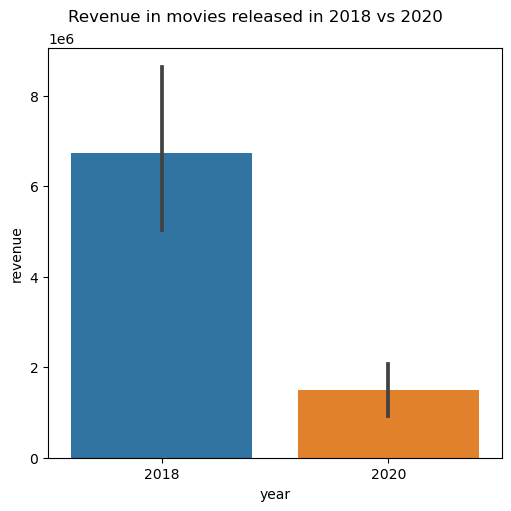

In [150]:
fig, ax = plt.subplots(figsize= (5,5), ncols=1, 
                                constrained_layout=True)
sns.barplot(data = rev_df, x='year',y='revenue')
fig.suptitle('Revenue in movies released in 2018 vs 2020');

## Notes

I will clean up this notebook when I am not working full time at my new job. I just don't have the time right now to fully dedicate to it. 